In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

# 1. Load Data

In [26]:
df = pd.read_csv('pseudo_sigmoid_batches_long.csv')

In [27]:
df

,batch,data_point,value
0,Batch_1,0.000000,0.000000
1,Batch_1,0.005005,0.000000
2,Batch_1,0.010010,0.111345
3,Batch_1,0.015015,0.230931
4,Batch_1,0.020020,0.000000
...,...,...,...
19995,Batch_20,4.979980,6.794403
19996,Batch_20,4.984985,7.000000
19997,Batch_20,4.989990,7.000000
19998,Batch_20,4.994995,6.884019


In [28]:
df = df.rename(columns = {'value':'Raw Signal', 'data_point':'Volume', 'batch':'Batch'})
#df_final = df_final[df_final["Batch"] == "Batch_1"]
df


,Batch,Volume,Raw Signal
0,Batch_1,0.000000,0.000000
1,Batch_1,0.005005,0.000000
2,Batch_1,0.010010,0.111345
3,Batch_1,0.015015,0.230931
4,Batch_1,0.020020,0.000000
...,...,...,...
19995,Batch_20,4.979980,6.794403
19996,Batch_20,4.984985,7.000000
19997,Batch_20,4.989990,7.000000
19998,Batch_20,4.994995,6.884019


# 2. Preprocess data

In [29]:
from preprocessing import process_dataframe

In [30]:
results = process_dataframe(df,batch_col='Batch', signal_col='Raw Signal', 
                      window_length=201, polyorder=2, num_smoothing_passes=2,
                      smoothed_col_name='smoothed_signal', 
                      normalized_col_name='normalized_signal',
                      derivative_col_name='first_derivative')

In [31]:
results

,Batch,Volume,Raw Signal,smoothed_signal,normalized_signal,first_derivative,normalized_first_derivative
0,Batch_1,0.000000,0.000000,0.070751,0.002366,-0.000066,0.000000
1,Batch_1,0.005005,0.000000,0.070298,0.002300,-0.000065,0.000128
2,Batch_1,0.010010,0.111345,0.069851,0.002235,-0.000064,0.000384
3,Batch_1,0.015015,0.230931,0.069410,0.002171,-0.000063,0.000640
4,Batch_1,0.020020,0.000000,0.068976,0.002108,-0.000063,0.000895
...,...,...,...,...,...,...,...
19995,Batch_20,4.979980,6.794403,6.906997,0.992620,-0.000173,0.001906
19996,Batch_20,4.984985,7.000000,6.905794,0.992446,-0.000175,0.001362
19997,Batch_20,4.989990,7.000000,6.904578,0.992270,-0.000177,0.000817
19998,Batch_20,4.994995,6.884019,6.903347,0.992092,-0.000179,0.000272


In [32]:
from plots import plot_processed_dataframe

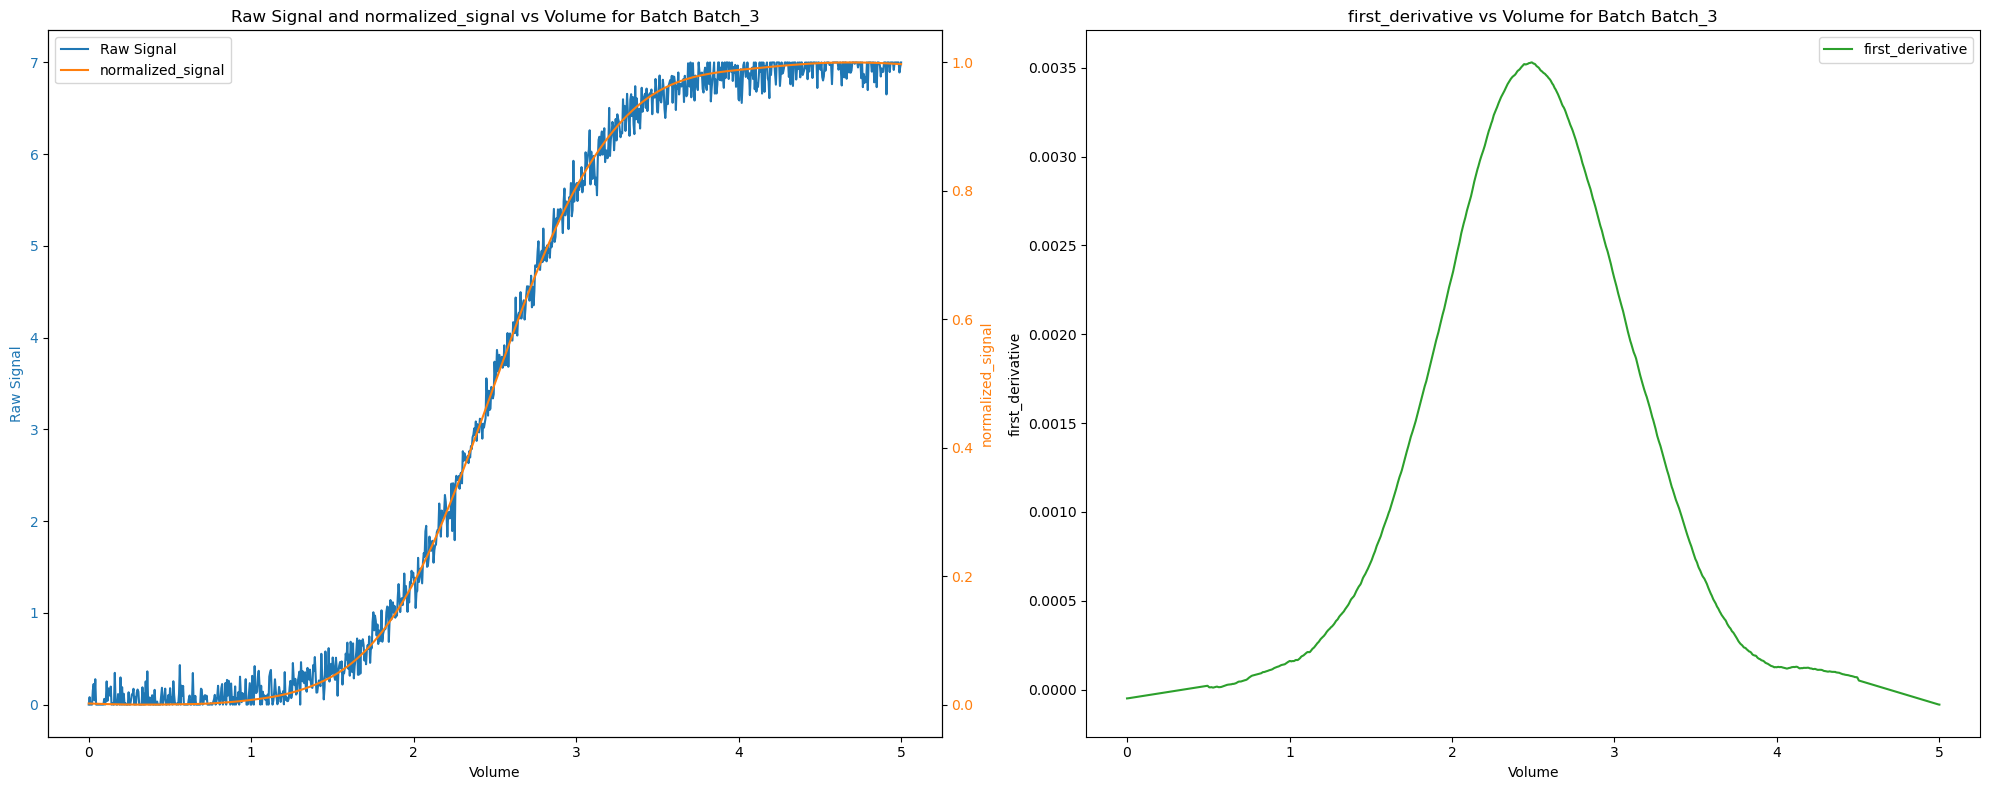

In [33]:
plot_processed_dataframe(df=results, 
                         volume_col="Volume",
                         raw_signal_col = "Raw Signal", 
                         processed_signal_col= "normalized_signal", 
                         derivative_col = "first_derivative", 
                         batch_col = "Batch", 
                         example_batch = "Batch_3") 

# 3. Metrics

In [34]:
from metrics import calculate_metrics
from metrics import calculate_control_limits

In [35]:
metrics = calculate_metrics(results, volume_col="Volume", signal_col="normalized_signal", deriv_col="normalized_first_derivative", batch_col='Batch')
metrics

/Users/vinniegaul/Documents/direct_transitional_analysis/metrics.py:260: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_derivative = smoothed_derivative.fillna(method='bfill').fillna(method='ffill')


,Batch,Direct AF,Transwidth,Inflection Points,Max Rate of Change
0,Batch_1,1.012248,1.971877,3,0.539625
1,Batch_2,1.012119,1.971711,1,0.732688
2,Batch_3,1.019753,1.933971,2,0.709790
3,Batch_4,0.991062,1.980847,6,0.639801
4,Batch_5,0.986935,1.961711,3,0.653633
5,Batch_6,0.980833,2.203583,4,0.692781
6,Batch_7,1.013012,1.961006,6,0.755414
7,Batch_8,1.005841,1.936042,4,0.553417
8,Batch_9,1.002533,1.997949,3,0.658865
9,Batch_10,0.995535,1.987869,1,0.700434


In [36]:
control_limits = calculate_control_limits(metrics)
control_limits

,Metric,Mean,LCL,UCL
0,Direct AF,1.003682,0.969335,1.038029
1,Transwidth,1.968745,1.692227,2.245263
2,Inflection Points,3.200000,-1.819960,8.219960
3,Max Rate of Change,0.652375,0.442131,0.862619


# 4. Control Charts

In [37]:
from plots import create_control_charts

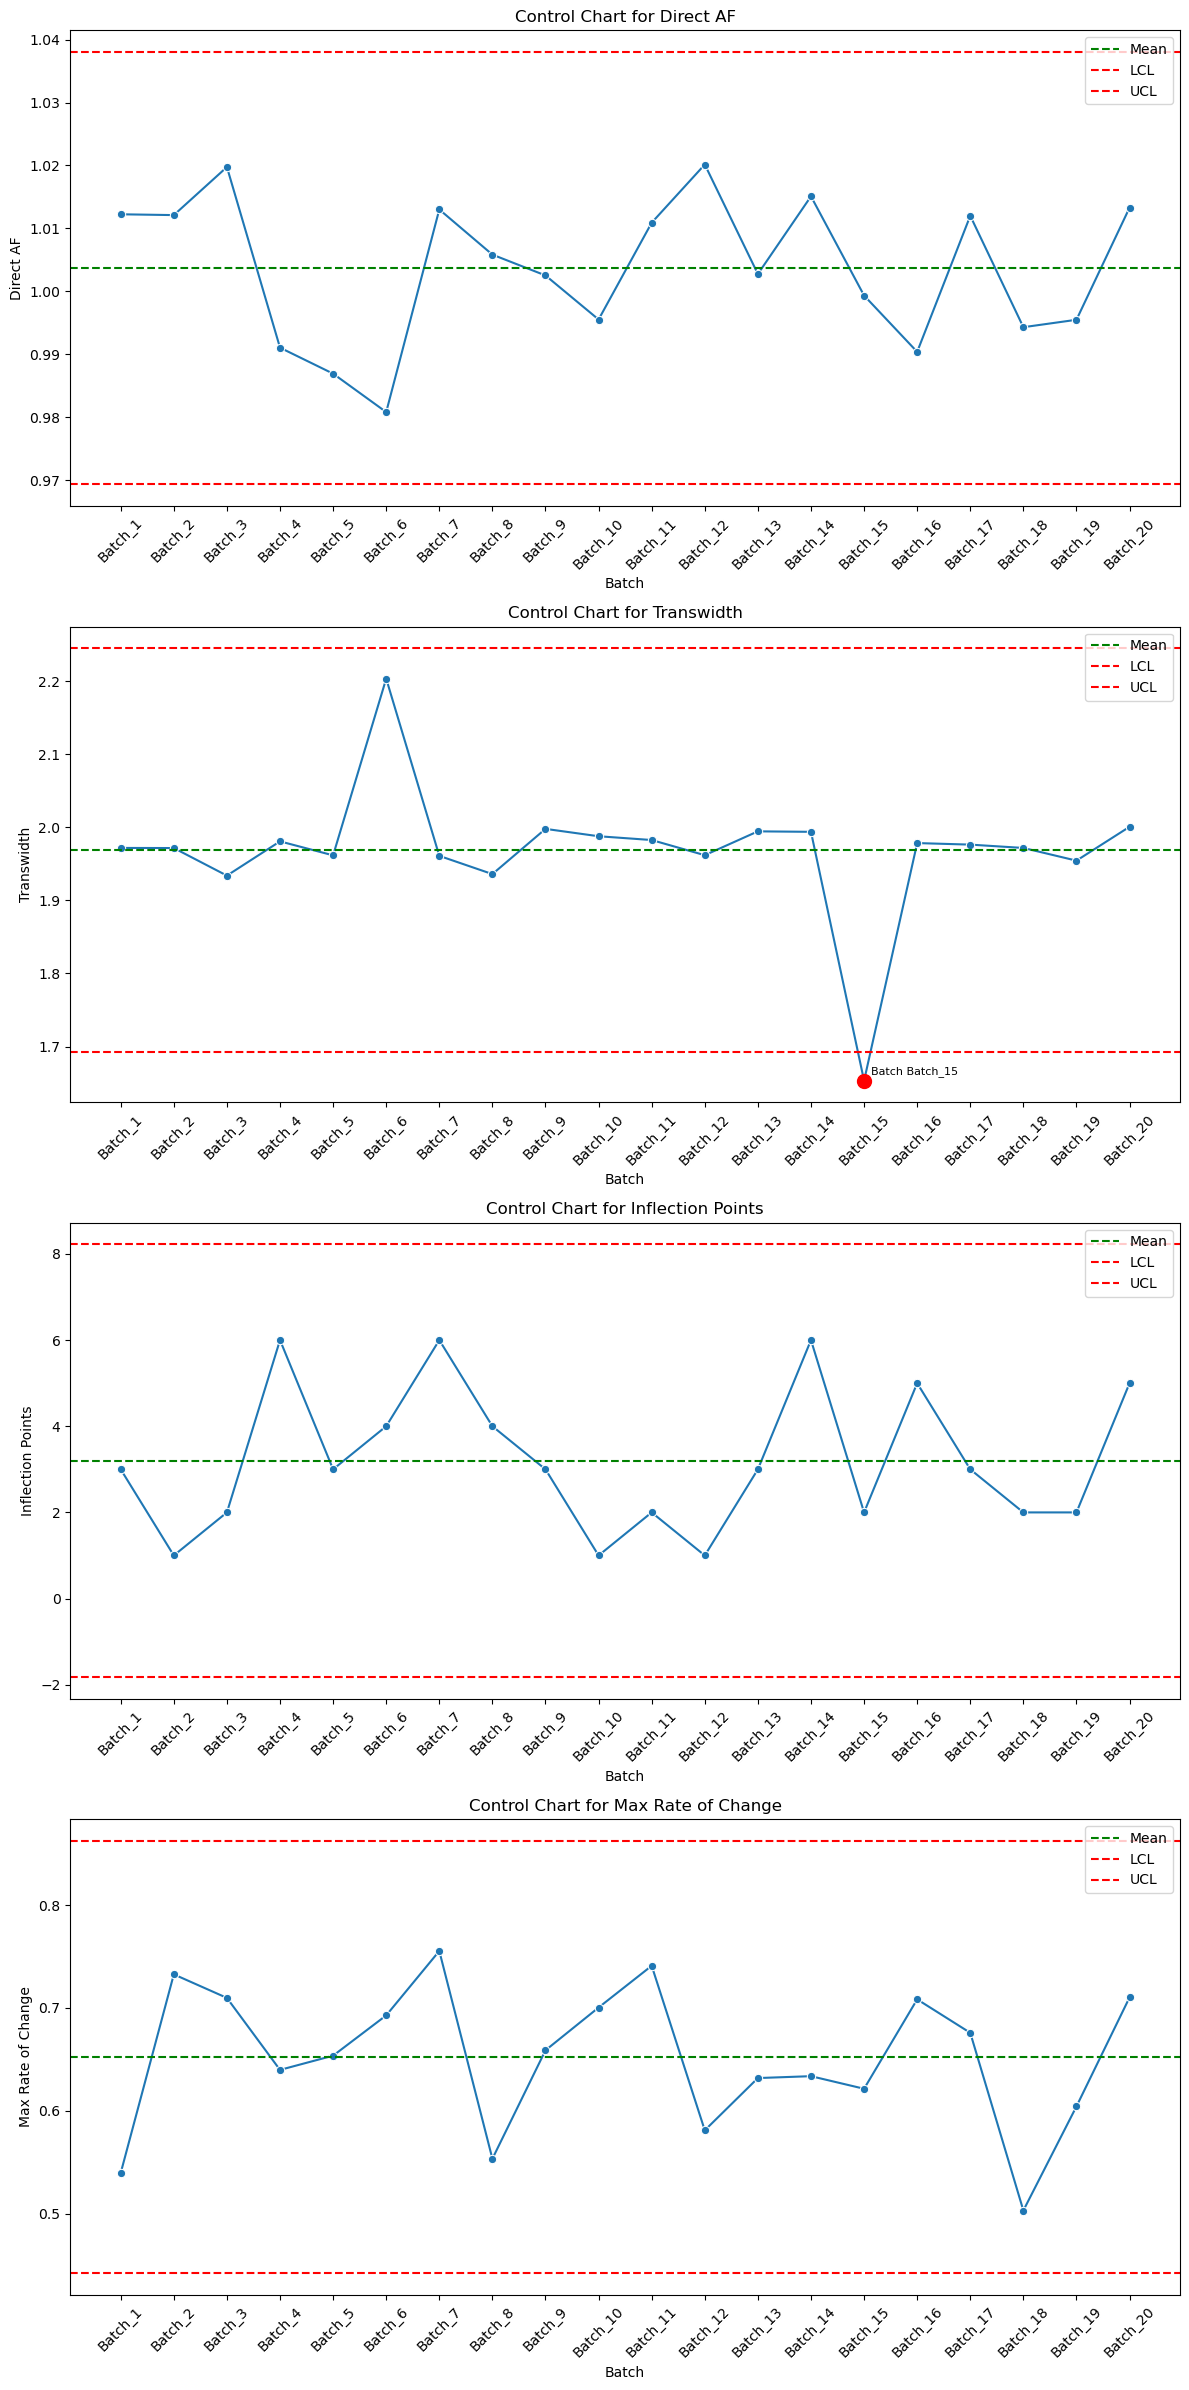

In [38]:
create_control_charts(metrics_df=metrics, control_limits_df=control_limits)

# 5. Exploratory Plots

In [39]:
def plot_signal(df, volume_col, signal_col, batch_col):
    
    plt.figure(figsize=(12, 12))
    sns.lineplot(data=df, x=volume_col, y=signal_col, hue=batch_col, alpha=0.5)
    plt.show()

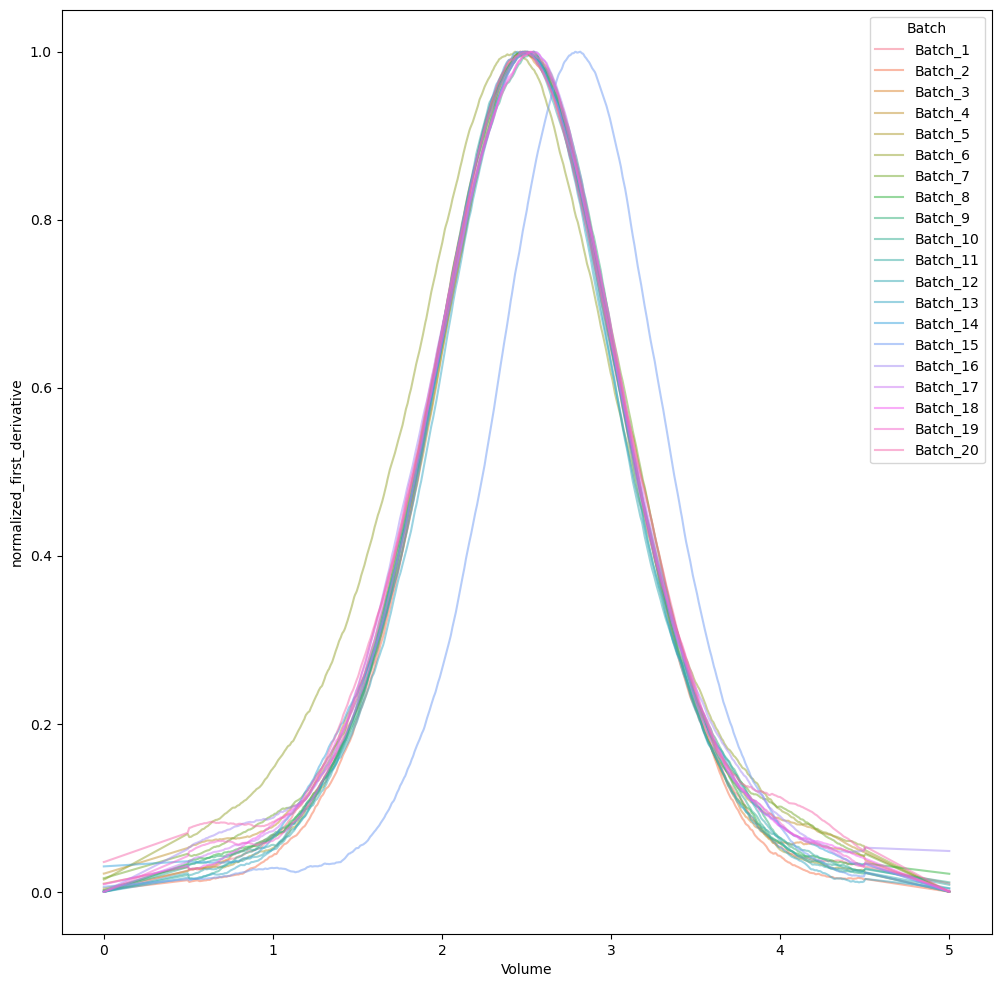

In [40]:
plot_signal(results, 'Volume', 'normalized_first_derivative', 'Batch')

In [41]:
from plots import plot_transwidth

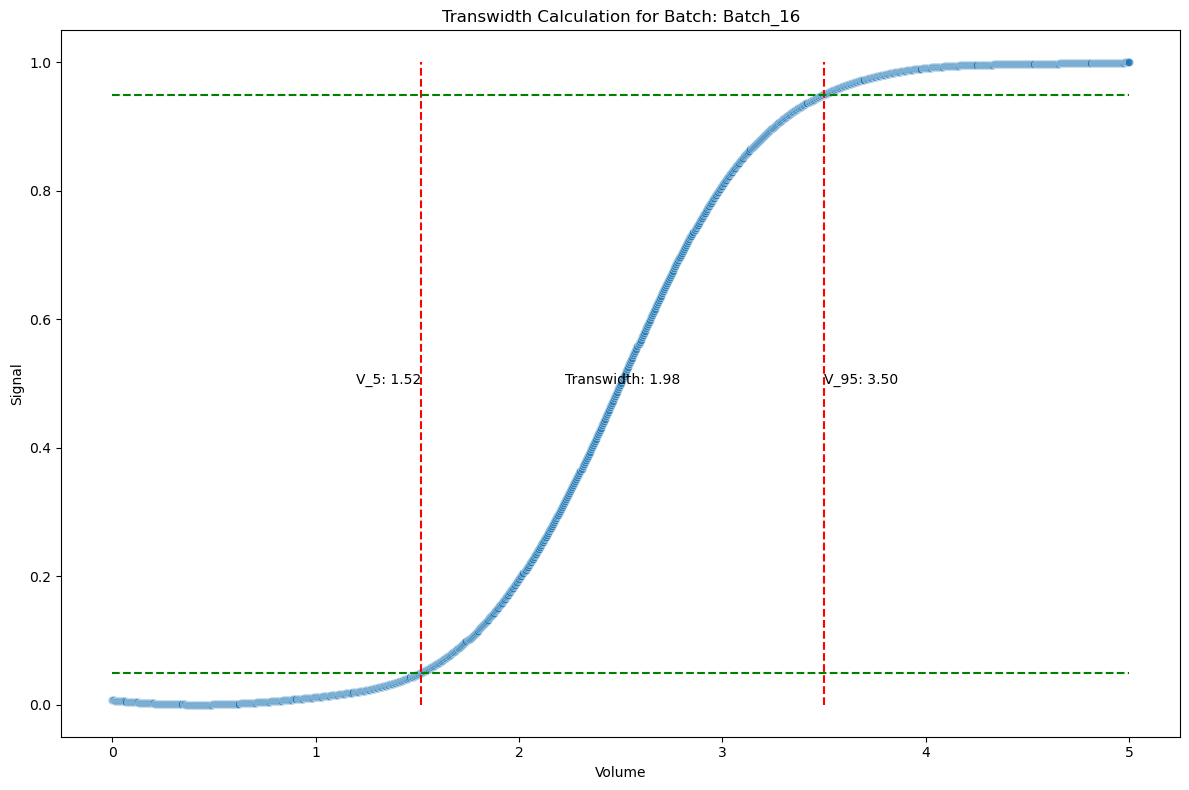

In [42]:

plot_transwidth(results, volume_col="Volume", signal_col="normalized_signal", batch_col="Batch", batch="Batch_16")

In [43]:
from plots import plot_direct_af

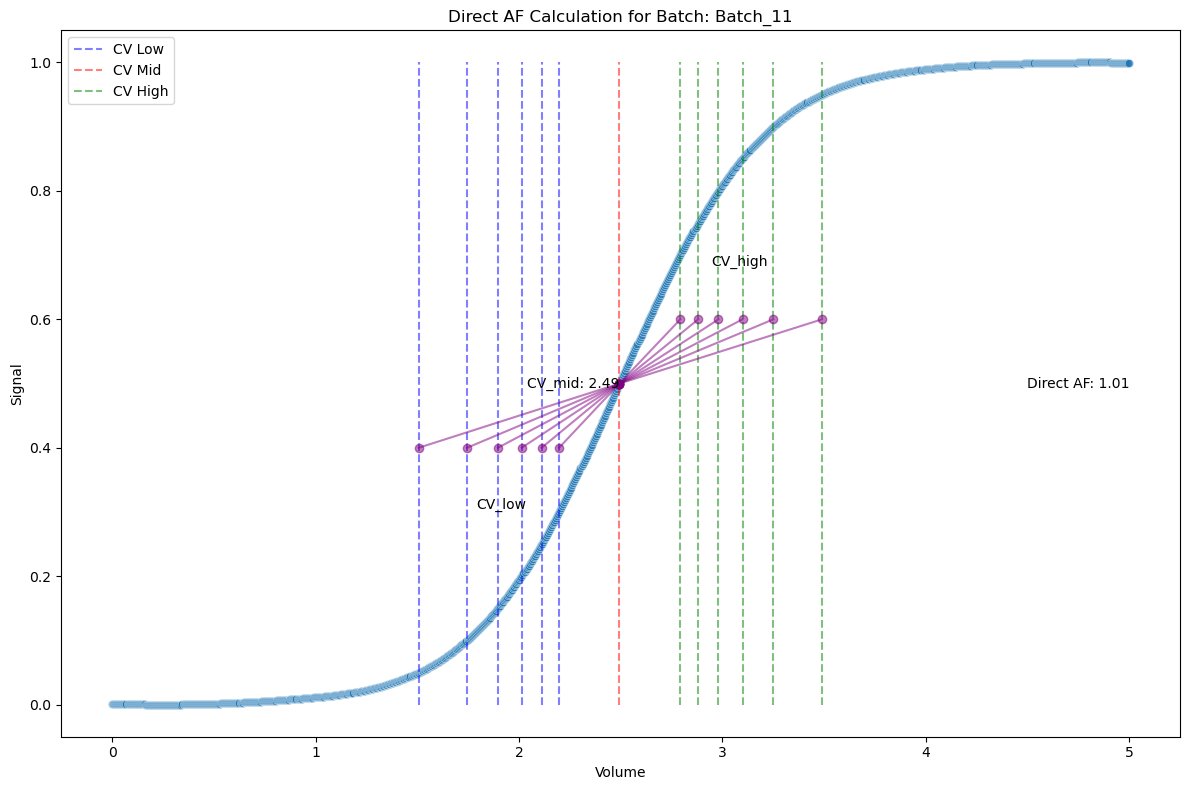

In [44]:
plot_direct_af(results, volume_col="Volume", signal_col="normalized_signal", batch_col="Batch", batch="Batch_11")

In [45]:
from plots import plot_inflection_points

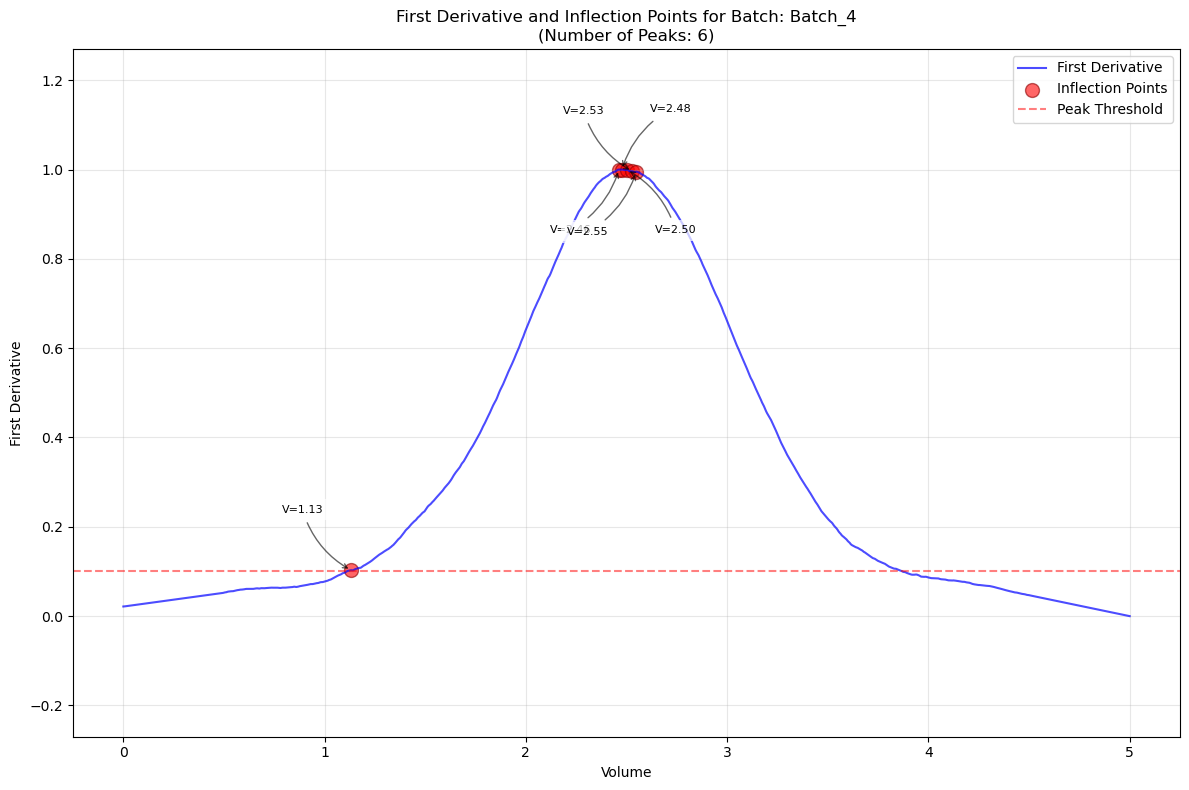

In [49]:
plot_inflection_points(df=results, volume_col="Volume", deriv_col="normalized_first_derivative", batch_col="Batch", batch="Batch_4")

In [47]:
from plots import plot_max_rate_of_change

/Users/vinniegaul/Documents/direct_transitional_analysis/plots.py:503: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_derivative = smoothed_derivative.fillna(method='bfill').fillna(method='ffill')


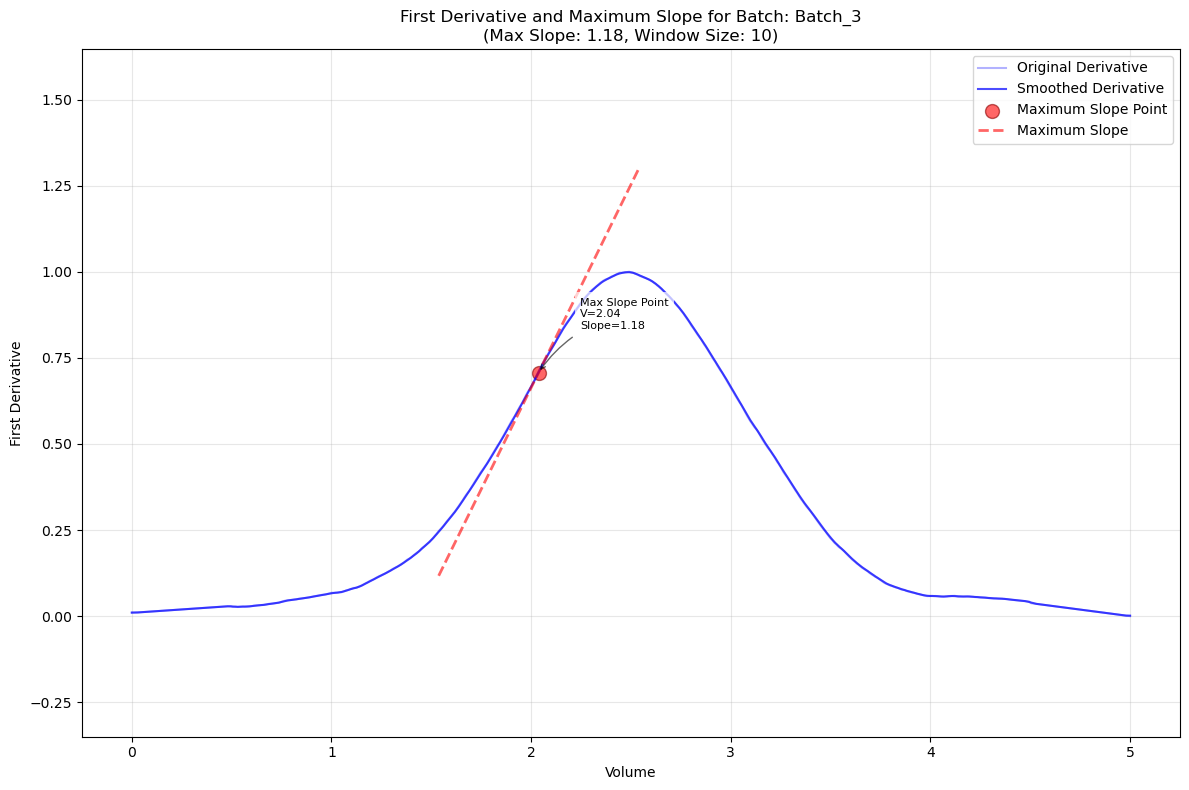

In [48]:
plot_max_rate_of_change(df=results, volume_col="Volume", deriv_col="normalized_first_derivative", batch_col="Batch", batch="Batch_3")